In [41]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
from sinPINN import Model

In [80]:
class Model(tf.Module):
    # One hidden layer model: 2w + 2b
    def __init__(self, layers):

        self.layers = layers
        # List of tf.Tensor objects
        self.W = []

        for i in range(len(layers) - 1):
            input_dim = layers[i]
            output_dim = layers[i + 1]

            w = tf.random.normal([output_dim, input_dim], 0, 1, dtype='float64')
            w = tf.Variable(w, trainable=True, name=f'w{i+1}')

            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.rate = 0.001
    
    def evaluate(self, x):
        # Computes u(x; theta)
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
     
    def rhs(self, x):
        # Right hand side of the PDE.
        # x: tf.Tensor
        return tf.math.cos(x)

    def get_weights(self):
        return self.W
    
    def set_weights(self, new_weights):
        # Setter for the parameters.
        # Shapes must coincide.
        for i in range(len(new_weights)):
            self.W[i].assign(new_weights[i])
        self.get_weights() 

    def reset_weights(self):
        return None

    ##################### LOSS FUNCTIONS ###########################

    def physics_loss(self, data_set):
        # MSE given by the PDE over data_set.
        # Note that, given the form of the NN, when the derivative w.r.t
        # x is taken, dependence on b_2 is lost. 
        
        # returns tf.Tensor shape=()

        l = []

        for x in data_set:
            x = tf.reshape(tf.Variable(x, trainable=False), (1,1))
            with tf.GradientTape() as tape:
                tape.watch(x)
                y = self.evaluate(x)
            u_x = tape.gradient(y, x)
            l.append(tf.subtract(u_x, self.rhs(x)))
            del tape
        loss = tf.math.reduce_mean(tf.math.multiply(l, l))
        return loss

    def boundary_condition(self):
        # PDE boundary condition.
        # output shape : () same as physical_loss()
        zero = tf.constant([[0]], dtype='float64')
        two_pi = tf.constant([[2 * np.pi]], dtype='float64')
        a = tf.add(self.evaluate(zero)**2, self.evaluate(two_pi)**2)
        return tf.reshape(a, ())

    def total_loss(self, data_set):
        # Loss computed from the PDE + loss from training data.
        # returns tf.Tensor shape=()

        return self.physics_loss(data_set) + self.boundary_condition()

    ##################### TRAINING FUNCTIONS ###########################


    def new_weight(self, old_W, gradients):
        # old_W: list of tensors
        # gradients: list of tensors
        # Computes: theta_{k+1} = t_k - \eta\grad L(\theta_k)
        new_W = []
        for w, grad in zip(old_W, gradients):
            aux = w - self.rate * grad
            new_W.append(aux)
        return new_W

    def gradients(self, data_set):
        # Performs one iteration of GD.
        # Since self.trainable_variables is constantly being updated,
        # the gradient is evaluated at different values of weights.
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            target = self.total_loss(data_set)
        gradients = tape.gradient(target, self.trainable_variables)
        return gradients
            
    def update(self, data_set):
        # Performs the update on the weights according to 
        # the gradient descent.
        old_w = self.get_weights()
        gradients = self.gradients(data_set)
        new_W = self.new_weight(old_w, gradients)
        self.set_weights(new_W)
    
    def train(self):
        # Generates a batch at each iteration
        num_iter = 1000
        for _ in tqdm(range(num_iter)):
        #for _ in range((num_iter)):
            data_set = np.random.uniform(0, 2 * np.pi, 20)
            self.update(data_set)
            #print(self.get_weights())
    
    def train_option(self, batches: list):
        for batch in batches:
            for _, x in enumerate(batch):
                #print(f'step {_}')
                with tf.GradientTape() as tape:
                    tape.watch(self.trainable_variables) 
                    target = self.total_loss(x)
                grads = tape.gradient(target, self.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
    ##################################################################
    


\begin{align}
\partial_x u_{\theta} &= cos(x)\\
u_{\theta}(0) &= 0\\
u_{\theta}(2\pi) &= 0.
\end{align}


In [81]:
model = Model([1,20,20,20,20,20,1])
data_set = np.random.uniform(0, 2 * np.pi, 20)

In [ ]:
# model.get_weights() test:

for tensor in model.get_weights():
    print('shape: ', tensor.shape, 'name: ', tensor.name)

In [23]:
# model.physical_lost(data_set) test:

model.physics_loss(data_set)
# returns tf.Tensor shape=()

In [ ]:
# model.total_loss(data_set) test:

model.total_loss(data_set)
# returns tf.Tensor shape=()

In [ ]:
# model.gradients(data_set) test:

for grad, weight in zip(model.gradients(data_set), model.get_weights()):
    print(weight.name)
    print('Weight shape: ', weight.shape)
    print('Gradient shape: ', grad.shape)
    print('-------------------------------------------')



In [82]:
model.train()

100%|██████████| 1000/1000 [01:59<00:00,  8.36it/s]


In [ ]:
model.get_weights()

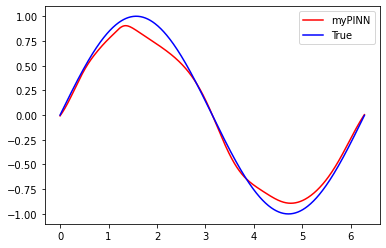

In [83]:
x = np.arange(0, 2 * np.pi, 0.01)
z = [tf.math.sin(v) for v in x]
y = [model.evaluate(v.reshape((1,1)))[0,0].numpy() for v in x]


plt.plot(x, y, color='r', label='myPINN')
plt.plot(x, z, color='b', label='True')

plt.legend()
plt.show()

In [ ]:
a = tf.cast(tf.constant(2, shape=(1,1)), dtype='float64')
tf.reshape(model.evaluate(a), ())

In [ ]:
W = tf.zeros([20, 1], dtype='float64')
a = tf.cast(tf.constant(2, shape=(1,1)), dtype='float64')
tf.matmul(W, a)